In [1]:
import numpy as np
import pandas as pd
import cv2
import glob
import os

x=np.empty([1000,28,28,3])
y=np.empty([1000,96])
g=np.empty([1000,96])
y_int=np.empty([1000])
g_int=np.empty([1000])

first = 1
for root, dirs, files in os.walk("/Users/momo/Downloads/openCV"):
	os.chdir(root)
	images = np.array([cv2.imread(file) for file in glob.glob(root+"/*.jpg")])
	num_of_images=images.shape[0]
	if num_of_images == 0:
		continue
	else:
		if first == 1:
			x = images
			name = os.path.basename(os.path.normpath(root))
			y.fill(0)
			num=0
			for i in range(0,999):
				y[i,num]=1
			y_int.fill(num)
			d={'strname':name,'intname':num}
			corr = pd.DataFrame(data = d,index=[num])
			first = 0
			num=num+1
		else:
			x = np.concatenate((x,images),axis=0)
			name = os.path.basename(os.path.normpath(root))
			g.fill(0)
			for i in range(0,999):
				g[i,num]=1
			y=np.concatenate((y,g),axis=0)
			g_int.fill(num)
			y_int=np.concatenate((y_int,g_int),axis=0)
			d={'strname' : name,'intname':num}
			newcorr = pd.DataFrame(data = d,index=[num])
			corr = corr.append(newcorr)
			num=num+1
x=np.reshape(x,[96000,2352])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test,y_int_train,y_int_test = train_test_split(x, y, y_int, test_size=0.25, random_state=42)

In [2]:
def get_batch(inputX, inputY,inputZ, batch_size):
    duration = len(inputX)
    for i in range(0,duration//batch_size):
        idx = i*batch_size
        yield inputX[idx:idx+batch_size], inputY[idx:idx+batch_size],inputZ[idx:idx+batch_size]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [4]:
img_size_flat = 2352
num_classes = 96

In [5]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [6]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [7]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [8]:
def new_FC_layer(x,units,activation,use_bias,name,reuse):
        num_ip = int(x.shape[1])
        num_op = units
        
        #kernel initializer
        #if kernel_initializer==xavier_initializer:
        #    initializer = tf.contrib.layers.xavier_initializer
        #    weight = tf.Variable(initializer([num_ip, num_op]),name='Weight')
        #else:
        
        if name:
            if reuse == True:
                with tf.variable_scope(name,reuse = tf.AUTO_REUSE):
                    weight = tf.get_variable("Weight",[num_ip, num_op],initializer=tf.zeros_initializer)
                    bias = tf.get_variable("Bias",[num_op],initializer=tf.zeros_initializer)
            else:
                with tf.variable_scope(name):
                    weight = tf.get_variable("Weight",[num_ip, num_op],initializer=tf.zeros_initializer)
                    bias = tf.get_variable("Bias",[num_op],initializer=tf.zeros_initializer)
        else:
            weight = tf.get_variable("Weight",[num_ip, num_op],initializer=tf.zeros_initializer)
            bias = tf.get_variable("Bias",[num_op],initializer=tf.zeros_initializer)
        
        if use_bias==False:
            layer = tf.matmul(x,weight)
        else:
            layer = tf.add(tf.matmul(x,weight),bias)
        if activation:
            layer = activation(layer)
        return layer

In [9]:
#h_layer1 = new_FC_layer(x,500,activation = tf.nn.sigmoid,use_bias=True,name='h_layer1',reuse=False)

In [10]:
#h_layer2= new_FC_layer(h_layer1,512,activation = tf.nn.relu,use_bias=True,name ='h_layer2',reuse=False)

In [11]:
#h_layer3= new_FC_layer(h_layer2,512,activation = tf.nn.relu,use_bias=True,name ='h_layer2',reuse=True)

In [12]:
logits = new_FC_layer(x,num_classes,activation = None,use_bias=True,name='op_layer',reuse=True)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
#tf.global_variables()

In [14]:
y_pred = tf.nn.softmax(logits)

In [15]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [17]:
cost = tf.reduce_mean(cross_entropy)

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [19]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [20]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
session= tf.Session()

In [22]:
session.run(tf.global_variables_initializer())

In [23]:
batch_size = 100

In [24]:
feed_dict_test = {x: x_test,
                  y_true: y_test,
                  y_true_cls: y_int_test}

In [25]:
def optimize(num_iterations):
    loss_list=[]
    acc_list=[]
    for i in range(num_iterations):
        batch = get_batch(x_train, y_train,y_int_train, batch_size)
        x_batch, y_true_batch,y_int_batch = next(batch)
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        if i % 100 == 0:
            loss=session.run(cost, feed_dict=feed_dict_train)
            acc = session.run(accuracy, feed_dict=feed_dict_test)
            loss_list.append(loss)
            acc_list.append(acc)
            plt.plot(loss_list)
            plt.plot(acc_list)

In [26]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [27]:
def print_confusion_matrix():
    cls_true = y_int_test
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(cm)

In [28]:
def find_performance_matrix(cm):
    
    performance_matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for class_num in range(10):
        performance_matrix[class_num][0] = find_precision(cm, class_num)
    for class_num in range(10):
        performance_matrix[class_num][1] = find_recall_rate(cm, class_num)
    for class_num in range(10):
        performance_matrix[class_num][2] = find_f_score(performance_matrix[class_num])

    #find mean precision, mean recall rate and mean f score
    for metric in range(3):
        total = 0
        for i in range(10):
            total += performance_matrix[i][metric]

        performance_matrix[10][metric] = total / 10

    round_off_performance_matrix(performance_matrix)

    return performance_matrix

def round_off_performance_matrix(performance_matrix):
    for i in range(len(performance_matrix)):
        for j in range(len(performance_matrix[i])):
            performance_matrix[i][j] = round(performance_matrix[i][j], 2)


def find_precision(cm, class_num):
    total_samples_classfied_as_class_num = 0
    for i in range(10):
        total_samples_classfied_as_class_num += cm[i][class_num]
    precision_rate = (cm[class_num][class_num] / total_samples_classfied_as_class_num) * 100

    return precision_rate

def find_recall_rate(cm, class_num):
    total_samples_in_class = 0
    for j in range(10):
        total_samples_in_class += cm[class_num][j]
    recall_rate = (cm[class_num][class_num] / total_samples_in_class) * 100

    return recall_rate

def find_f_score(array):
    precision = array[0]
    recall = array[1]
    f_score = (precision * recall) / ((precision + recall) / 2)

    return f_score

In [29]:
print_accuracy()

Accuracy on test-set: 1.1%


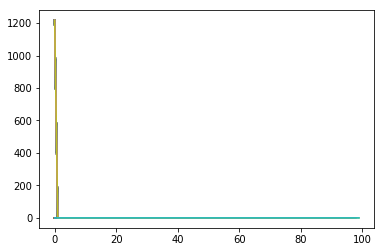

In [30]:
optimize(num_iterations=10000)

In [31]:
print_accuracy()

Accuracy on test-set: 5.5%


[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  8]
 ...
 [ 0  0 11 ...  0  0  9]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 14 ...  0  0 18]]


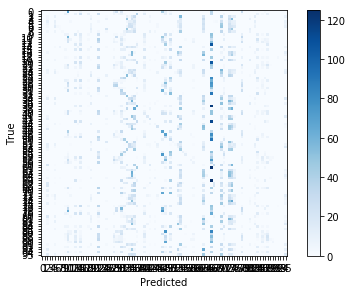

In [32]:
cm = print_confusion_matrix()

In [33]:
pm = find_performance_matrix(cm)
print(pm)

[[nan, nan, nan], [nan, 0.0, nan], [10.71, 25.0, 15.0], [nan, 0.0, nan], [nan, 0.0, nan], [17.02, 61.54, 26.67], [100.0, 10.53, 19.05], [50.0, 100.0, 66.67], [100.0, 16.67, 28.57], [46.67, 100.0, 63.64], [nan, nan, nan]]


/Users/momo/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars
/Users/momo/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


In [34]:
f_score = pm[-1][-1]
print(f_score)

nan


In [35]:
#saver = tf.train.Saver()
#save_path = saver.save(session, "/Users/momo/Documents/DL/Tuts/Tf/new/model1.ckpt",global_step=1000)
#print("Model saved in path: %s" % save_path)

In [36]:
#session.close()